In [46]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
experiment_name = 'd01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])

In [48]:
time_window = 25
time_step = 25
trial_bin_size = 20
n_splits = 1000
group_dict = OrderedDict([('1 (very dissimilar)',[11]),('1 (dissimilar)',[12]),('1 (similar)',[13]),('2',[20])])
train_labels = ['1 (very dissimilar)','2']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=train_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [4]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.group_labels(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, y_train = wrangl.select_training_data(X_train_all, y_train) 
        X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)

        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

interp = eeg_decoder.Interpreter(clfr, subtitle='hyperplane')
interp.save_results(timestamp=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [49]:
interp = eeg_decoder.Interpreter()
interp.load_results('hyperplane')

0
Significant timepoints: [160 184 208 232 256 280 304 328 352 376 400 424 448 472 496 520 544 568
 592 616 640 664 688 712 736 760 784 808 832 856 880 904 928 952]
1
Significant timepoints: [160 184 208 232 256 280 304 328 352 376 400 424 448 472 496 520 544 568
 592 616 640 664 688 712 736 760 784 808 832 856 880 904 928 952]
2
Significant timepoints: [184 208 232 256 280 304 328 352 376 400 424 448 472 496 520 544 568 592
 616 640 664 688 712 736 760 784 808 832 856 880 904 928 952]
Saving output\figures\hyperplane1v2new.pdf
Saving output\figures\hyperplane1v2new.png


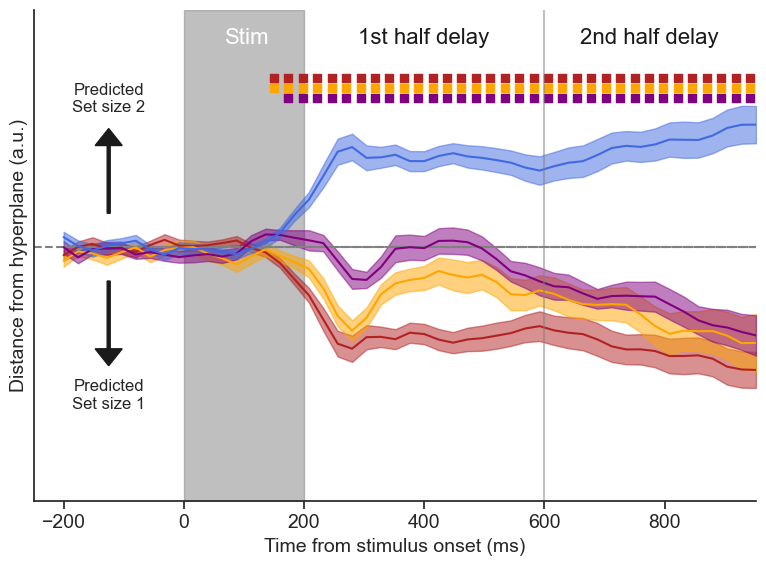

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.close()

sns.set_theme(font_scale=1.5,style='white')
plt.subplots(figsize=(8,6))

interp.colors = ['firebrick', 'orange','purple','royalblue']
interp.labels = ['1 targ. + very dissim. dist.','1 targ. + dissim. distractor', '1 target + sim. distractor', '2 targets']
interp.plot_hyperplane(
    stim_time=[0,200], 
    significance_testing_pair=[(0,3),(1,3),(2,3)],
    sig_y=2.5,
    test_from_zero=False,
    ylim=[-3.75,3.5],stim_label_xy=[120,3.1],
    label_text_ys=[-1.95,1.95],label_text_x=-125,
    arrow_ys=[-.5,.5],add_delay_labels=True,
    arrow_labels=['Set size 1','Set size 2'],
    savefig=True,subtitle='1v2new',legend_pos=None)

# break it up into time windows

In [50]:
import numpy as np
import pandas as pd
def get_condition_means(conf_scores, time_idx=None):

    if time_idx is None:
        delay_acc =np.mean(np.mean(interp.confidence_scores,2),1)
    else:
        delay_acc =np.mean(np.mean(interp.confidence_scores[:,time_idx],2),1)

    subject_means = pd.DataFrame(delay_acc,columns=list(group_dict.keys()))
    labels = list(group_dict.keys())
    subject_means['Subject'] = np.arange(exp.nsub)

    x = subject_means.melt(id_vars='Subject',value_vars=labels,var_name='Condition',value_name='Distance from Hyperplane')
    condition_means = x.groupby('Condition').mean()['Distance from Hyperplane'].to_numpy()
    return x, condition_means

In [106]:
stim_time_idx = (interp.t>0)&(interp.t<200)
first_half_time_idx = (interp.t>200)&(interp.t<600)
second_half_time_idx = (interp.t>600)
x_0, condition_means_0 = get_condition_means(interp.confidence_scores,stim_time_idx)
x_1, condition_means_1 = get_condition_means(interp.confidence_scores,first_half_time_idx)
x_2, condition_means_2 = get_condition_means(interp.confidence_scores,second_half_time_idx)

# violin

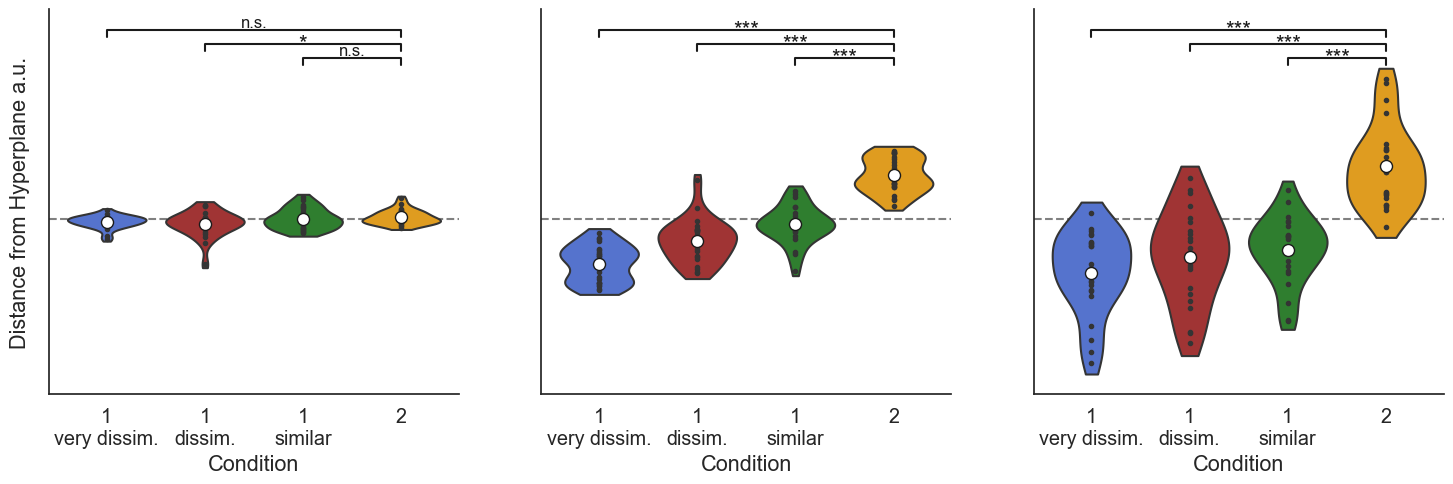

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(font_scale=1.3,style='white',rc=custom_params)

fig,ax = plt.subplots(1,3,figsize=(18,5),sharey=True)

### Stim
ax[0].axhline(y=0, color='grey', linestyle='--',zorder=-10)
sns.violinplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_0,ax=ax[0],palette= interp.colors[:4],
    dodge=True,inner='points',cut=.5,scale='width')
ax[0].scatter(
    x = [0,1,2,3],
    y = [condition_means_0[2],condition_means_0[0],condition_means_0[1],condition_means_0[3]],
    c = 'white', edgecolors='k',s=75)
ax[0].set_ylabel('Distance from Hyperplane a.u.')
ax[0].set_yticklabels([])

stat_y,stat_h = 5.2, .2
ax[0].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(1.5, stat_y+stat_h+.014, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)

stat_y,stat_h = 4.8, .2
ax[0].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(2, stat_y+stat_h-.25, '*', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 4.4, .2
ax[0].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(2.5, stat_y+stat_h+.014, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)

### First half
ax[1].axhline(y=0, color='grey', linestyle='--',zorder=-10)
sns.violinplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_1,ax=ax[1],palette= interp.colors[:4],
    dodge=True,inner='points',cut=.5,scale='width')
ax[1].scatter(
    x = [0,1,2,3],
    y = [condition_means_1[2],condition_means_1[0],condition_means_1[1],condition_means_1[3]],
    c = 'white', edgecolors='k',s=75)
ax[1].set_ylabel('')

stat_y,stat_h = 5.2, .2
ax[1].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(1.5, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 4.8, .2
ax[1].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(2, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 4.4, .2
ax[1].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(2.5, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

### Second half
ax[2].axhline(y=0, color='grey', linestyle='--',zorder=-10)
sns.violinplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_2,ax=ax[2],palette= interp.colors[:4],
    dodge=True,inner='points',cut=.5,scale='width')
ax[2].scatter(
    x = [0,1,2,3],
    y = [condition_means_2[2],condition_means_2[0],condition_means_2[1],condition_means_2[3]],
    c = 'white', edgecolors='k',s=75)
ax[2].set_ylabel('')

stat_y,stat_h = 5.2, .2
ax[2].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(1.5, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 4.8, .2
ax[2].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(2, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 4.4, .2
ax[2].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(2.5, stat_y+stat_h-.25, '***', ha='center', va='bottom', color='k', fontsize=16)

for a in ax:
    a.set_ylim(-5,6)
    a.set_xticklabels(['1\nvery dissim.','1\ndissim.','1\nsimilar','2'])

plt.savefig('output/figures/hyperplane_violin.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/hyperplane_violin.pdf',dpi=500,bbox_inches='tight')
plt.show()

# bar

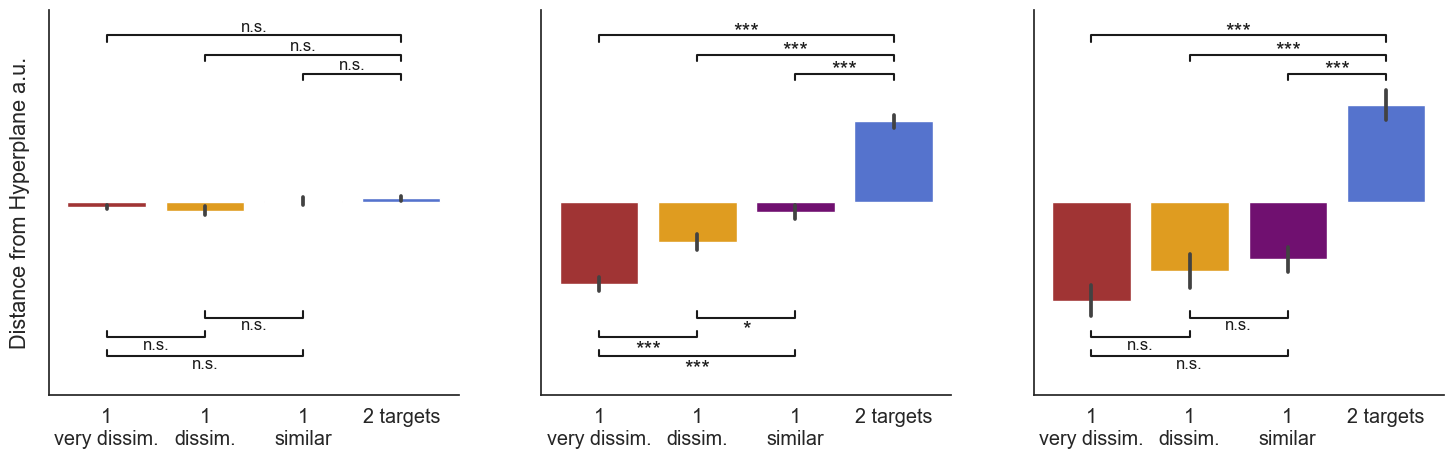

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(font_scale=1.3,style='white',rc=custom_params)

fig,ax = plt.subplots(1,3,figsize=(18,5),sharey=True)

### Stim
# ax[0].axhline(y=0, color='grey', linestyle='-',zorder=-10)
sns.barplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_0,ax=ax[0],palette= interp.colors[:4],
    dodge=True,errorbar='se')
ax[0].set_ylabel('Distance from Hyperplane a.u.')
ax[0].set_yticklabels([])

# 0,3
stat_y,stat_h = 2.5, .1
ax[0].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(1.5, stat_y+stat_h+.014, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)
# 1,3
stat_y,stat_h = 2.2, .1
ax[0].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(2, stat_y+stat_h+.014, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)
# 2,3
stat_y,stat_h = 1.9, .1
ax[0].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[0].text(2.5, stat_y+stat_h+.014, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)

# 0,1
stat_y,stat_h = -2, .1
ax[0].plot([0, 0, 1, 1], [stat_y,stat_y-stat_h,stat_y-stat_h,stat_y], lw=1.5, c='k')
ax[0].text(.5, stat_y-stat_h-.24, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)
# 0,2
stat_y,stat_h = -2.3, .1
ax[0].plot([0, 0, 2, 2], [stat_y,stat_y-stat_h,stat_y-stat_h,stat_y], lw=1.5, c='k')
ax[0].text(1, stat_y-stat_h-.24, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)
# 1,2
stat_y,stat_h = -1.7, .1
ax[0].plot([1, 1, 2, 2], [stat_y,stat_y-stat_h,stat_y-stat_h,stat_y], lw=1.5, c='k')
ax[0].text(1.5, stat_y-stat_h-.24, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)

### First half
sns.barplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_1,ax=ax[1],palette= interp.colors[:4],
    dodge=True,errorbar='se')
ax[1].set_ylabel('')

stat_y,stat_h = 2.5, .1
ax[1].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(1.5, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 2.2, .1
ax[1].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(2, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 1.9, .1
ax[1].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[1].text(2.5, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

# 0,1
stat_y,stat_h = -2, .1
ax[1].plot([0, 0, 1, 1], [stat_y,stat_y-stat_h,stat_y-stat_h,stat_y], lw=1.5, c='k')
ax[1].text(.5, stat_y-stat_h-.35, '***', ha='center', va='bottom', color='k', fontsize=16)
# 0,2
stat_y,stat_h = -2.3, .1
ax[1].plot([0, 0, 2, 2], [stat_y,stat_y-stat_h,stat_y-stat_h,stat_y], lw=1.5, c='k')
ax[1].text(1, stat_y-stat_h-.35, '***', ha='center', va='bottom', color='k', fontsize=16)
# 1,2
stat_y,stat_h = -1.7, .1
ax[1].plot([1, 1, 2, 2], [stat_y,stat_y-stat_h,stat_y-stat_h,stat_y], lw=1.5, c='k')
ax[1].text(1.5, stat_y-stat_h-.35, '*', ha='center', va='bottom', color='k', fontsize=16)

### Second half
sns.barplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_2,ax=ax[2],palette= interp.colors[:4],
    dodge=True,errorbar='se')
ax[2].set_ylabel('')

stat_y,stat_h = 2.5, .1
ax[2].plot([0, 0, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(1.5, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 2.2, .1
ax[2].plot([1, 1, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(2, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

stat_y,stat_h = 1.9, .1
ax[2].plot([2, 2, 3, 3], [stat_y,stat_y+stat_h,stat_y+stat_h,stat_y], lw=1.5, c='k')
ax[2].text(2.5, stat_y+stat_h-.1, '***', ha='center', va='bottom', color='k', fontsize=16)

# 0,1
stat_y,stat_h = -2, .1
ax[2].plot([0, 0, 1, 1], [stat_y,stat_y-stat_h,stat_y-stat_h,stat_y], lw=1.5, c='k')
ax[2].text(.5, stat_y-stat_h-.24, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)
# 0,2
stat_y,stat_h = -2.3, .1
ax[2].plot([0, 0, 2, 2], [stat_y,stat_y-stat_h,stat_y-stat_h,stat_y], lw=1.5, c='k')
ax[2].text(1, stat_y-stat_h-.24, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)
# 1,2
stat_y,stat_h = -1.7, .1
ax[2].plot([1, 1, 2, 2], [stat_y,stat_y-stat_h,stat_y-stat_h,stat_y], lw=1.5, c='k')
ax[2].text(1.5, stat_y-stat_h-.24, 'n.s.', ha='center', va='bottom', color='k', fontsize=12)

for a in ax:
    a.set_ylim(-3,3)
    a.set_xticklabels(['1\nvery dissim.','1\ndissim.','1\nsimilar','2 targets'])
    a.set_xlabel('')

plt.savefig('output/figures/hyperplane_bar.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/hyperplane_bar.pdf',dpi=500,bbox_inches='tight')
plt.show()

In [52]:
x_0['window'] = 'stim'
x_1['window'] = 'first_half'
x_2['window'] = 'second_half'
all_windows = pd.concat([x_0,x_1,x_2])

In [54]:
import pingouin
def grab_cond_and_window(cond, window):
    return all_windows.query(f'window=="{window}" & Condition=="{cond}"')['Distance from Hyperplane']

# tukey

In [64]:
from scipy.stats import tukey_hsd

In [141]:
res = tukey_hsd(
    grab_cond_and_window("1 (very dissimilar)", "stim"),grab_cond_and_window("1 (dissimilar)", "stim"),grab_cond_and_window("1 (similar)", "stim"),grab_cond_and_window("2", "stim")
)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.055     0.896    -0.150     0.260
 (0 - 2)     -0.091     0.651    -0.296     0.114
 (0 - 3)     -0.135     0.318    -0.340     0.070
 (1 - 0)     -0.055     0.896    -0.260     0.150
 (1 - 2)     -0.146     0.250    -0.351     0.059
 (1 - 3)     -0.190     0.080    -0.395     0.015
 (2 - 0)      0.091     0.651    -0.114     0.296
 (2 - 1)      0.146     0.250    -0.059     0.351
 (2 - 3)     -0.044     0.944    -0.248     0.161
 (3 - 0)      0.135     0.318    -0.070     0.340
 (3 - 1)      0.190     0.080    -0.015     0.395
 (3 - 2)      0.044     0.944    -0.161     0.248



In [142]:
res.__dict__['statistic']

array([[ 0.        ,  0.05490573, -0.09116493, -0.13482655],
       [-0.05490573,  0.        , -0.14607066, -0.18973227],
       [ 0.09116493,  0.14607066,  0.        , -0.04366162],
       [ 0.13482655,  0.18973227,  0.04366162,  0.        ]])

In [70]:
res = tukey_hsd(
    grab_cond_and_window("1 (very dissimilar)", "first_half"),grab_cond_and_window("1 (dissimilar)", "first_half"),grab_cond_and_window("1 (similar)", "first_half"),grab_cond_and_window("2", "first_half")
)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.654     0.000    -1.062    -0.247
 (0 - 2)     -1.126     0.000    -1.533    -0.718
 (0 - 3)     -2.534     0.000    -2.942    -2.127
 (1 - 0)      0.654     0.000     0.247     1.062
 (1 - 2)     -0.472     0.017    -0.879    -0.064
 (1 - 3)     -1.880     0.000    -2.288    -1.473
 (2 - 0)      1.126     0.000     0.718     1.533
 (2 - 1)      0.472     0.017     0.064     0.879
 (2 - 3)     -1.409     0.000    -1.816    -1.001
 (3 - 0)      2.534     0.000     2.127     2.942
 (3 - 1)      1.880     0.000     1.473     2.288
 (3 - 2)      1.409     0.000     1.001     1.816



In [71]:
res = tukey_hsd(
    grab_cond_and_window("1 (very dissimilar)", "second_half"),grab_cond_and_window("1 (dissimilar)", "second_half"),grab_cond_and_window("1 (similar)", "second_half"),grab_cond_and_window("2", "second_half")
)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.457     0.516    -1.324     0.411
 (0 - 2)     -0.648     0.213    -1.515     0.220
 (0 - 3)     -3.052     0.000    -3.920    -2.185
 (1 - 0)      0.457     0.516    -0.411     1.324
 (1 - 2)     -0.191     0.939    -1.058     0.676
 (1 - 3)     -2.595     0.000    -3.463    -1.728
 (2 - 0)      0.648     0.213    -0.220     1.515
 (2 - 1)      0.191     0.939    -0.676     1.058
 (2 - 3)     -2.405     0.000    -3.272    -1.537
 (3 - 0)      3.052     0.000     2.185     3.920
 (3 - 1)      2.595     0.000     1.728     3.463
 (3 - 2)      2.405     0.000     1.537     3.272



# different from 2

In [56]:
# STIM
stim_df = pd.concat([pingouin.ttest(grab_cond_and_window("1 (very dissimilar)", "stim"),grab_cond_and_window("2", "stim"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (dissimilar)", "stim"),grab_cond_and_window("2", "stim"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (similar)", "stim"),grab_cond_and_window("2", "stim"),paired=True)])
stim_df['time'] = 'Stim'
stim_df['comparison'] = ['vdiss_2','diss_2','sim_2']

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,time,comparison
T-test,-1.703191,23,two-sided,0.102010,"[-0.3, 0.03]",0.687003,0.752,0.896552,Stim,vdiss_2
T-test,-2.170539,23,two-sided,0.040538,"[-0.37, -0.01]",0.642311,1.536,0.853814,Stim,diss_2
T-test,-0.579683,23,two-sided,0.567764,"[-0.2, 0.11]",0.173180,0.25,0.128557,Stim,sim_2


In [57]:
# first_half
first_df = pd.concat([pingouin.ttest(grab_cond_and_window("1 (very dissimilar)", "first_half"),grab_cond_and_window("2", "first_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (dissimilar)", "first_half"),grab_cond_and_window("2", "first_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (similar)", "first_half"),grab_cond_and_window("2", "first_half"),paired=True)])
first_df['time'] = 'First half'
first_df['comparison'] = ['vdiss_2','diss_2','sim_2']

In [58]:
# second_half 
second_df = pd.concat([pingouin.ttest(grab_cond_and_window("1 (very dissimilar)", "second_half"),grab_cond_and_window("2", "second_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (dissimilar)", "second_half"),grab_cond_and_window("2", "second_half"),paired=True),
pingouin.ttest(grab_cond_and_window("1 (similar)", "second_half"),grab_cond_and_window("2", "second_half"),paired=True)])
second_df['time'] = 'Second half'
second_df['comparison'] = ['vdiss_2','diss_2','sim_2']

In [61]:
all_comparison_df = pd.concat([stim_df, first_df,second_df],axis=0)
all_comparison_df

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,time,comparison
T-test,-1.703191,23,two-sided,1.020096e-01,"[-0.3, 0.03]",0.687003,0.752,0.896552,Stim,vdiss_2
T-test,-2.170539,23,two-sided,4.053820e-02,"[-0.37, -0.01]",0.642311,1.536,0.853814,Stim,diss_2
T-test,-0.579683,23,two-sided,5.677640e-01,"[-0.2, 0.11]",0.173180,0.25,0.128557,Stim,sim_2
T-test,-12.352187,23,two-sided,1.238136e-11,"[-2.96, -2.11]",5.030123,6.932e+08,1.000000,First half,vdiss_2
T-test,-10.195575,23,two-sided,5.297809e-10,"[-2.26, -1.5]",3.386210,2.013e+07,1.000000,First half,diss_2
T-test,-9.831495,23,two-sided,1.052421e-09,"[-1.7, -1.11]",2.753917,1.057e+07,1.000000,First half,sim_2
T-test,-6.477476,23,two-sided,1.308574e-06,"[-4.03, -2.08]",2.642809,1.397e+04,1.000000,Second half,vdiss_2
T-test,-5.405526,23,two-sided,1.715563e-05,"[-3.59, -1.6]",2.106555,1329.046,1.000000,Second half,diss_2
T-test,-6.262303,23,two-sided,2.171927e-06,"[-3.2, -1.61]",2.277176,8772.558,1.000000,Second half,sim_2


In [62]:
all_windows.groupby(['window','Condition']).agg(['mean','std'])['Distance from Hyperplane']

mean       std
window      Condition                              
first_half  1 (dissimilar)      -0.620835  0.612177
            1 (similar)         -0.149183  0.530431
            1 (very dissimilar) -1.275065  0.515634
            2                    1.259381  0.491792
second_half 1 (dissimilar)      -1.075626  1.306249
            1 (similar)         -0.884748  0.948823
            1 (very dissimilar) -1.532497  1.156745
            2                    1.519835  1.153168
stim        1 (dissimilar)      -0.128842  0.363669
            1 (similar)          0.017229  0.291325
            1 (very dissimilar) -0.073936  0.186482
            2                    0.060890  0.205560

# different from 0